In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
!wget --no-check-certificate -nc 'https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_' -O spam.csv

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

--2022-04-23 17:57:59--  https://docs.google.com/uc?export=download&id=1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_
Resolving docs.google.com (docs.google.com)... 74.125.139.100, 74.125.139.138, 74.125.139.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.139.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9t26ugr5tgq6543gapeg9g8damsui341/1650736650000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download [following]
--2022-04-23 17:58:00--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9t26ugr5tgq6543gapeg9g8damsui341/1650736650000/08702983968081230261/*/1U5KcTiBcw9RX9lyKD8vrXb4vxzwb8h8_?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.goo

In [3]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [4]:
# rename columns to something better
df.columns = ['labels', 'data']

In [5]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [6]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7112 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train :', data_train.shape)

Shape of data train : (3733, 162)


In [10]:
# get sequence length
T = data_train.shape[1]

In [11]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test:', data_test.shape)

Shape of data test: (1839, 162)


In [12]:
# Create the model

# Hyperparameter: Embedding Dimensionality
D = 20

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [13]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest)
)


Training model...
Epoch 1/5
117/117 [==============================] - 15s 16ms/step - loss: 0.3792 - accuracy: 0.8679 - val_loss: 0.2817 - val_accuracy: 0.8559
Epoch 2/5
117/117 [==============================] - 1s 13ms/step - loss: 0.1389 - accuracy: 0.9400 - val_loss: 0.0895 - val_accuracy: 0.9755
Epoch 3/5
117/117 [==============================] - 1s 12ms/step - loss: 0.0238 - accuracy: 0.9949 - val_loss: 0.0600 - val_accuracy: 0.9810
Epoch 4/5
117/117 [==============================] - 1s 11ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0763 - val_accuracy: 0.9799
Epoch 5/5
117/117 [==============================] - 2s 13ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0726 - val_accuracy: 0.9821


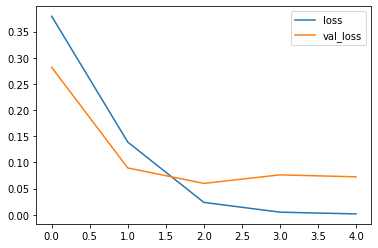

In [14]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

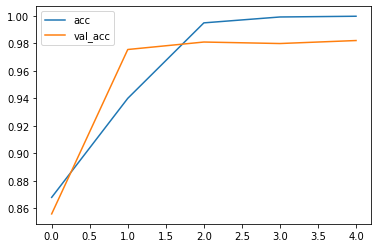

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()